In [1]:
import numpy as np
import skimage
import skimage.io
import math

import matplotlib.pyplot as plt

In [2]:
!ls

Dataset  project.ipynb	tp1  tp2  tp4


In [3]:
!ls Dataset/

108005.jpg  157055.jpg	253027.jpg  41033.jpg  8023.jpg
12084.jpg   163085.jpg	260058.jpg  58060.jpg


In [4]:
import glob

path_images = glob.glob("./Dataset/*")
list_images = []
for img in path_images:
    im = skimage.io.imread(img)
    list_images.append(im)
    
len(list_images)

9

## TP1 - SuperPixel (SLIC)

In [5]:
class Cluster:
    
    cluster_index = 1
    
    def __init__(self, l, a, b, x, y):
        self.l = l
        self.a = a
        self.b = b
        self.x = x
        self.y = y
        
        self.t = np.array([l, a, b, x, y]).T
        self.pixel = []
        self.lbp = None
        
        self.number = self.cluster_index
        Cluster.cluster_index += 1
        
    def update(self, l, a, b, x, y):
        self.l = l
        self.a = a
        self.b = b
        self.x = x
        self.y = y
        
        self.t = np.array([l, a, b, x, y]).T
        return self
    
    def add_lbp(self, lbp):
        self.lbp = lbp

In [6]:
def init_cluster(image, S):
    cluster = []
    x = S // 2
    y = S // 2
    nb_col = 0
    while x < image.shape[0]:
        nb_lignes = 0
        while y < image.shape[1]:
            C_k = Cluster(image[x, y, 0], image[x, y, 1], image[x, y, 2], int(x), int(y))
            cluster.append(C_k)
            y += S // 2
            nb_lignes += 1
        #print(nb_lignes)
        x += S // 2
        y = S // 2
        nb_col += 1
    return (nb_col, cluster)

def gradient(image, x, y):
    x = int(x)
    y = int(y)
    if x + 1 >= image.shape[0]:
        x = image.shape[0] - 2
    if y + 1 >= image.shape[1]:
        y = image.shape[1] - 2

    gradient = image[x + 1][y + 1][0] - image[x][y][0] + \
               image[x + 1][y + 1][1] - image[x][y][1] + \
               image[x + 1][y + 1][2] - image[x][y][2]
    return gradient

def move_cluster(image, clusters):
    counter = 0
    for cluster in clusters:
        grad = gradient(image, cluster.x, cluster.y)
        for derx in range(-1, 2):
            for dery in range(-1, 2):
                x = (cluster.x) + derx
                y = (cluster.y) + dery
                #print(x, y)
                new_grad = gradient(image, x, y)
                if new_grad < grad:
                    cluster.update(image[x, y, 0], image[x, y, 1], image[x, y, 2], x, y)
                    grad = new_grad
        counter += 1


def assign(image, clusters, S, dis, res, m=40):
    counter = 0
    for C_k in clusters:
        for x in range((C_k.x) - 2 * S, (C_k.x) + 2 * S):
            if x < 0 or x >= image.shape[0]:
                continue
            for y in range((C_k.y) - 2 * S, (C_k.y) + 2 * S):
                if y < 0 or y >= image.shape[1]:
                    continue
                
                d_lab = math.sqrt((image[x,y,0] - C_k.l)**2 + (image[x,y,1] - C_k.a)**2 + (image[x,y,2] - C_k.b)**2)
                d_xy = math.sqrt((x - C_k.x)**2 + (y - C_k.y)**2)
                D = d_lab + (m / S) * d_xy
                
                if D < dis[x, y]:
                    if (x, y) not in res:
                        res[(x, y)] = C_k
                        C_k.pixel.append((x, y))
                    else:
                        res[(x, y)].pixel.remove((x, y))
                        res[(x, y)] = C_k
                        C_k.pixel.append((x, y))
                    dis[x , y] = D
                
        counter += 1
    return (res, dis)


def update_cluster(image, clusters):
    for C_k in clusters:
        sum_x = 0
        sum_y = 0
        number = 0
        for pix in C_k.pixel:
            sum_x += pix[0]
            sum_y += pix[1]
            number += 1
            x = int(sum_x / number)
            y = int(sum_y / number)
            
            C_k.update(image[x, y, 0], image[x, y, 1], image[x, y, 2], x, y)
            
def save_current_image(image, cluster):
    image_arr = np.copy(image)
    for C_k in cluster:
        for p in C_k.pixel:
            image_arr[p[0], p[1], 0] = C_k.l
            image_arr[p[0], p[1], 1] = C_k.a
            image_arr[p[0], p[1], 2] = C_k.b
    return image_arr

def super_pixel(image, K):
    print(image.shape)
    N = image.shape[0] * image.shape[1]
    S = int(math.sqrt(N / K))
    
    lab_image = skimage.color.rgb2lab(image)
    nb_col, cluster = init_cluster(lab_image, S)
    print("nb clusters: ", len(cluster))
    move_cluster(lab_image, cluster)
    res = {}
    dis = np.full((image.shape[0], image.shape[1]), np.inf)
    (res, dis) = assign(lab_image, cluster, S, dis, res)
    update_cluster(lab_image, cluster)
        
    out_image =  save_current_image(lab_image, cluster)
    return (cluster, nb_col, len(cluster) // nb_col, out_image)

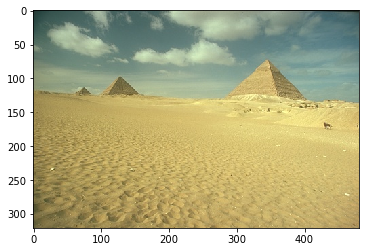

In [7]:
plt.imshow(list_images[0])

(321, 481, 3)
nb clusters:  400


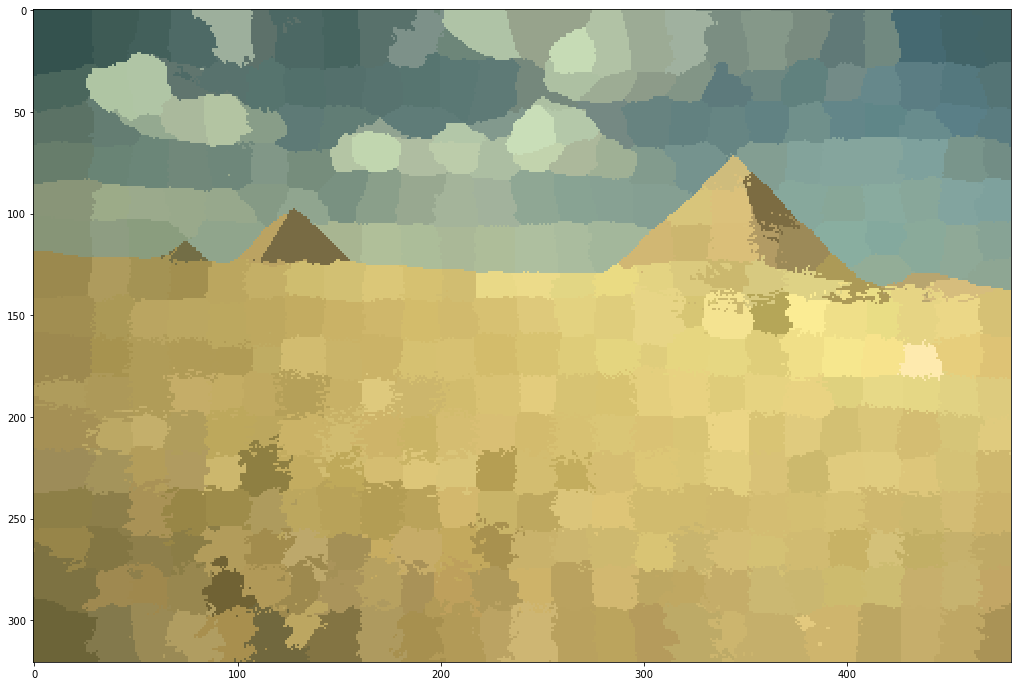

In [8]:
clusters,x,y,final_image = super_pixel(list_images[0], 100)

plt.figure(figsize=(20, 12))

plt.imshow(skimage.color.lab2rgb(final_image))
plt.show()

## TP2 - Local Binary Pattern 

In [9]:
def lbp(image, neighboor=3):
    gray_image = skimage.color.rgb2gray(image)
    output = gray_image.copy()
    val = neighboor//2
    print(val)
    for i in range(val, gray_image.shape[0] - val):
        for j in range(val,  gray_image.shape[1] - val):
            im = gray_image[i-val:i+val+1, j-val:j+val+1]
            ref = im[val, val]
            im = im.flatten()
            im = np.delete(im, len(im) // 2)
            res = 0
            for k in range(len(im)):
                if im[k] >= ref:
                    res += 2**k
                    
            output[i,j] = res / 255.
    return output

1


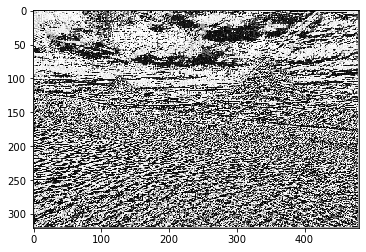

In [10]:
out = lbp(list_images[0])

plt.imshow(out, cmap='gray')

# TP3 - Incorporate texture information into Superpixels segmentation

## Exercice 1

In [11]:
def another_assign(image, clusters, S, dis, res, lbp_im, cluster_lbp, m=40):
    counter = 0
    for C_k in clusters:
        for x in range((C_k.x) - 2 * S, (C_k.x) + 2 * S):
            if x < 0 or x >= image.shape[0]:
                continue
            for y in range((C_k.y) - 2 * S, (C_k.y) + 2 * S):
                if y < 0 or y >= image.shape[1]:
                    continue
                
                d_lab = math.sqrt((image[x,y,0] - C_k.l)**2 + (image[x,y,1] - C_k.a)**2 + (image[x,y,2] - C_k.b)**2)
                d_xy = math.sqrt((x - C_k.x)**2 + (y - C_k.y)**2)
                d_lbp = abs(cluster_lbp[counter].lbp - lbp_im[x, y])
                D = d_lab + (m / S) * d_xy + d_lbp
                
                if D < dis[x, y]:
                    if (x, y) not in res:
                        res[(x, y)] = C_k
                        C_k.pixel.append((x, y))
                    else:
                        res[(x, y)].pixel.remove((x, y))
                        res[(x, y)] = C_k
                        C_k.pixel.append((x, y))
                    dis[x , y] = D
                
        counter += 1
    return (res, dis)


def another_super_pixel(image, K, lbp_image, cluster_lbp):
    print(image.shape)
    N = image.shape[0] * image.shape[1]
    S = int(math.sqrt(N / K))
    
    lab_image = skimage.color.rgb2lab(image)
    nb_col, cluster = init_cluster(lab_image, S)
    print("nb clusters: ", len(cluster))
    move_cluster(lab_image, cluster)
    res = {}
    dis = np.full((image.shape[0], image.shape[1]), np.inf)
    (res, dis) = another_assign(lab_image, cluster, S, dis, res, lbp_image, cluster_lbp)
    update_cluster(lab_image, cluster)
        
    out_image =  save_current_image(lab_image, cluster)
    return out_image

In [12]:
def SLICLBP(image, K, m=40, neighboor=3, radius=1):
    lbp_image = lbp(image, neighboor=neighboor)
    cluster, nb_col, nb_ligne, image_out = super_pixel(image, K)
    
    gray_image = skimage.color.lab2rgb(image_out)
    gray_image = skimage.color.rgb2gray(gray_image)
    
    output = gray_image.copy()
    
    print(nb_col)
    print(nb_ligne)
    print(len(cluster))
    
    ctn = 0
    
    for i in range(0, nb_ligne):
        for j in range(0, nb_col):
            
            X = []
            
            # Get top
            if i != 0:
                if j != 0:
                    X.append(cluster[j - 1 + nb_col * (i - 1)])

                X.append(cluster[j + nb_col * (i - 1)])
                if j + 1 < nb_col:
                    X.append(cluster[(j + 1) + nb_col * (i - 1)])
            
            
            # Get middle
            if j != 0:
                X.append(cluster[j - 1 + nb_col * i])
            
            if j + 1 < nb_col:
                X.append(cluster[j + 1 + nb_col * i])
            
            # Get bottom
            if i + 1 < nb_col:
                if j != 0:
                    X.append(cluster[(j - 1) + nb_col * (i + 1)])
                
                X.append(cluster[(j) + nb_col * (i + 1)])
                
                if j + 1 < nb_col:
                    X.append(cluster[(j + 1) + nb_col * (i + 1)])

            clus = cluster[j + nb_col * i]

            if len(clus.pixel) == 0:
                print("t")
                continue
            pos_x, pos_y = clus.pixel[0] 
            ref = gray_image[pos_x, pos_y]
            res = 0
            
            for k in range(len(X)):
                if len(X[k].pixel) == 0:
                    print("ratp")
                    continue
                if gray_image[X[k].pixel[0]] >= ref:
                    res += 2**k
            for x, y in clus.pixel:
                output[x, y] = res / 255.
            cluster[ctn].lbp = res
            ctn += 1
    
    print("Antoher SLIC")
    output_image_final = another_super_pixel(image, K, lbp_image, cluster_lbp=cluster)
            
    return output_image_final

1
(321, 481, 3)
nb clusters:  400
16
25
400
Antoher SLIC
(321, 481, 3)
nb clusters:  400
CPU times: user 2min 54s, sys: 66 ms, total: 2min 54s
Wall time: 2min 54s


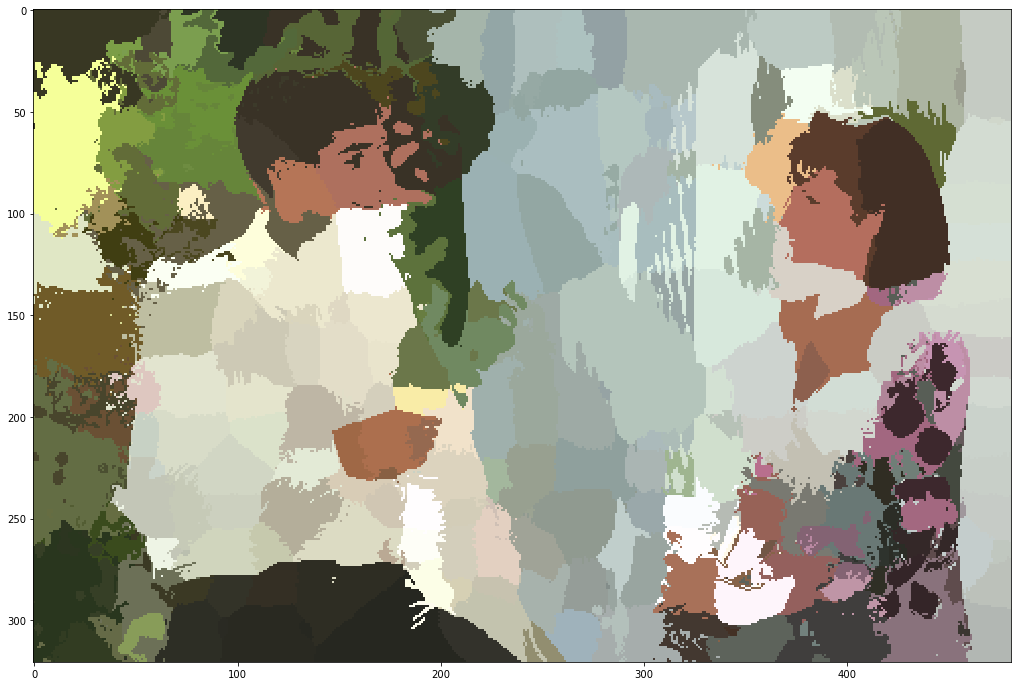

In [13]:
plt.figure(figsize=(20, 12))
%time out_img = SLICLBP(list_images[1], 100)

plt.imshow(skimage.color.lab2rgb(out_img), cmap="gray")

In [17]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import watershed, disk
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

image = img_as_ubyte(skimage.color.rgb2gray(skimage.color.lab2rgb(out_img)))

# denoise image
denoised = rank.median(image, disk(2))

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(5)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(2))

# process the watershed
labels = watershed(gradient, markers)

(481,)


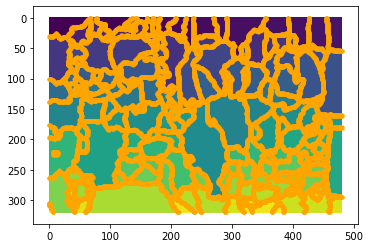

In [38]:
from skimage.segmentation import find_boundaries

plt.imshow(labels)

bound = find_boundaries(labels).astype('int')
print(bound[3].shape)

x_val = []
y_val = []

for i in range(bound.shape[0]):
    for j in range(bound.shape[1]):
        if bound[i,j]:
            x_val.append(j)
            y_val.append(i)

plt.scatter(x_val, y_val, s=10, color="orange")

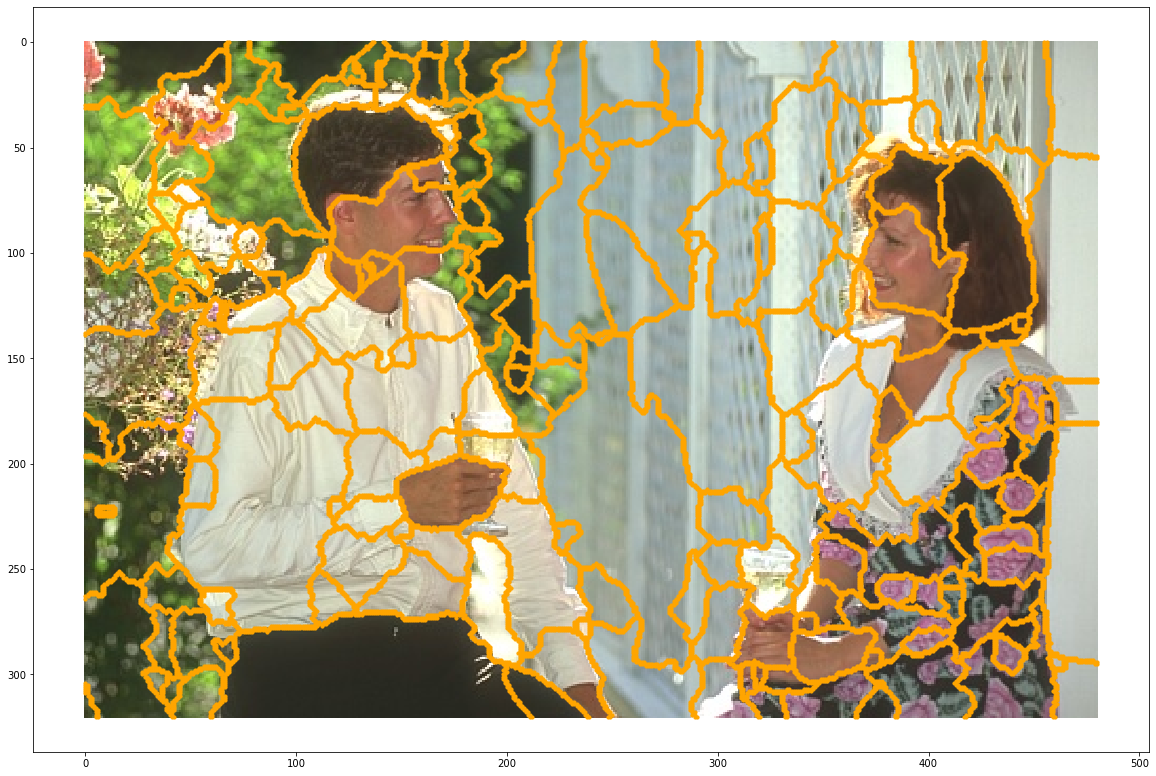

In [40]:
plt.figure(figsize=(20, 15))
plt.imshow(list_images[1])

plt.scatter(x_val, y_val, s=10, color="orange")